In [1]:
import psycopg2

connection = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret',
)

In [2]:
import pandas as pd

cursor = connection.cursor()
cursor.execute(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    GROUP BY registration_day
    ORDER BY registration_day
    """
    )
dates_and_registrations = cursor.fetchall()
df = pd.DataFrame(dates_and_registrations, columns=['registration_day', 'num_registrations'])
df['registration_day'] = pd.to_datetime(df['registration_day'])
if df.index[-1] != pd.to_datetime('today').normalize():
    df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
user_registrations = df.set_index('registration_day').resample('D').sum().fillna(value=0)

cursor = connection.cursor()
cursor.execute(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    AND (metadata_public->>'lastLogin') IS NOT NULL
    AND (metadata_public->>'lastLogin')::date > created_at::date
    GROUP BY registration_day
    ORDER BY registration_day;
    """
    )
dates_and_registrations = cursor.fetchall()
df = pd.DataFrame(dates_and_registrations, columns=['registration_day', 'num_registrations'])
df['registration_day'] = pd.to_datetime(df['registration_day'])
if df.index[-1] != pd.to_datetime('today').normalize():
    df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
users_registrations_that_logged_in_again_on_a_different_day = df.set_index('registration_day').resample('D').sum().fillna(value=0)

Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!



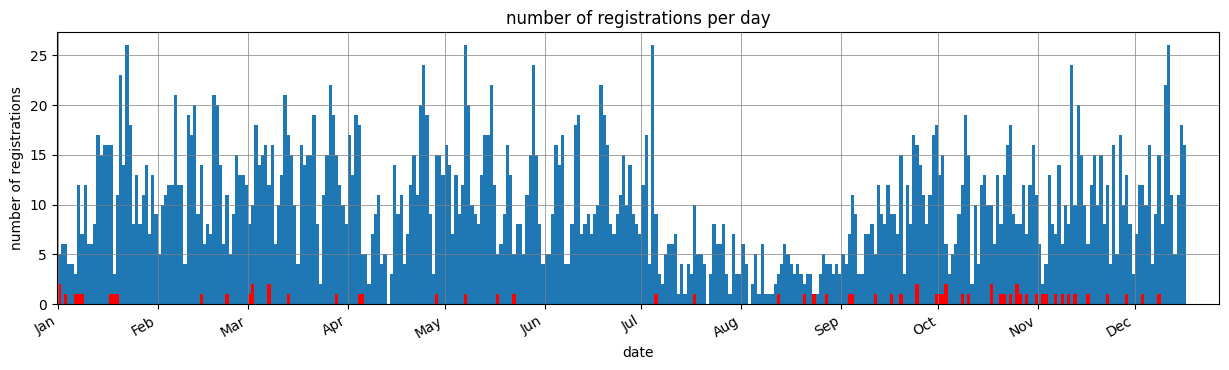

In [3]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("""Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!
""")

fig, ax = plt.subplots(figsize=(15, 4))
user_registrations['num_registrations'].plot(kind='bar', width=1.0, align='edge')
users_registrations_that_logged_in_again_on_a_different_day['num_registrations'].plot(kind='bar', width=1.0, align='edge', color='red')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('date')
today = datetime.today()
#plt.xlim([today-timedelta(365), today])
plt.ylabel('number of registrations')
plt.title('number of registrations per day')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()